This quickstart notebook allows to test and mess around with the MLPF GNN model in a standalone way. For actual training, we don't use a notebook, please refer to `README.md`.


```bash
git clone https://github.com/jpata/particleflow/
```

Run the notebook from `notebooks/delphes-tf-mlpf-quickstart.ipynb`.

In [1]:
import bz2, pickle
import numpy as np
import tensorflow as tf
import sklearn
import sklearn.metrics
import matplotlib.pyplot as plt

In [2]:
import sys
sys.path += ["../mlpf"]

In [3]:
import tfmodel

In [4]:
!wget --no-check-certiow to ficate -nc https://zenodo.org/record/4452283/files/tev14_pythia8_ttbar_0_0.pkl.bz2

'wget' is not recognized as an internal or external command,
operable program or batch file.


In [4]:
data = pickle.load(bz2.BZ2File("tev14_pythia8_ttbar_0_0.pkl.bz2", "r"))

In [5]:
#100 events in one file
len(data["X"]), len(data["ygen"])

(100, 100)

In [6]:
#Pad the number of elements to a size that's divisible by the bin size
Xs = []
ys = []

max_size = 50*128
for i in range(len(data["X"])):
    X = data["X"][i][:max_size, :]
    y = data["ygen"][i][:max_size, :]
    Xpad = np.pad(X, [(0, max_size - X.shape[0]), (0, 0)])
    ypad = np.pad(y, [(0, max_size - y.shape[0]), (0, 0)])
    Xpad = Xpad.astype(np.float32)
    ypad = ypad.astype(np.float32)
    Xs.append(Xpad)
    ys.append(ypad)
    
X = np.stack(Xs)
y = np.stack(ys)

In [7]:
#Get the first event
input_classes = np.unique(X[:, :, 0].flatten())
output_classes = np.unique(y[:, :, 0].flatten())
num_output_classes = len(output_classes)

In [9]:
input_classes

array([0., 1., 2.], dtype=float32)

In [10]:
output_classes

array([0., 1., 2., 3., 4., 5.], dtype=float32)

In [8]:
def transform_target(y):
    return {
        "cls": tf.one_hot(tf.cast(y[:, :, 0], tf.int32), num_output_classes),
        "charge": y[:, :, 1:2],
        "pt": y[:, :, 2:3],
        "eta": y[:, :, 3:4],
        "sin_phi": y[:, :, 4:5],
        "cos_phi": y[:, :, 5:6],
        "energy": y[:, :, 6:7],
    }
yt = transform_target(y)

In [9]:
from tfmodel.model import PFNetDense

In [10]:
msk_true_particle = y[:, :, 0]!=0

In [11]:
np.unique(y[msk_true_particle][:, 0], return_counts=True)

(array([1., 2., 3., 4., 5.], dtype=float32),
 array([263996,  93508, 133732,    912,    278], dtype=int64))

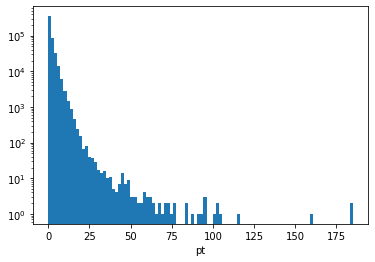

In [15]:
plt.hist(yt["pt"][msk_true_particle].flatten(), bins=100);
plt.xlabel("pt")
plt.yscale("log")

Text(0.5, 0, 'eta')

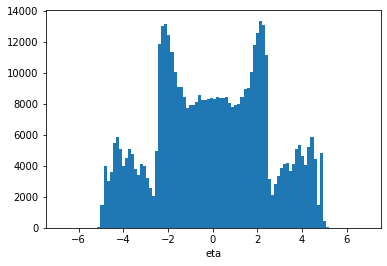

In [16]:
plt.hist(yt["eta"][msk_true_particle].flatten(), bins=100);
plt.xlabel("eta")

Text(0.5, 0, 'sin phi')

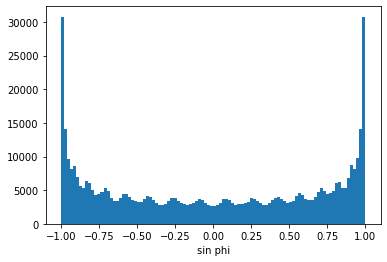

In [17]:
plt.hist(yt["sin_phi"][msk_true_particle].flatten(), bins=100);
plt.xlabel("sin phi")

Text(0.5, 0, 'cos phi')

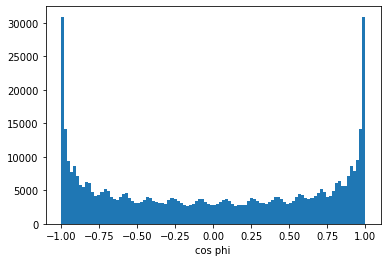

In [18]:
plt.hist(yt["cos_phi"][msk_true_particle].flatten(), bins=100);
plt.xlabel("cos phi")

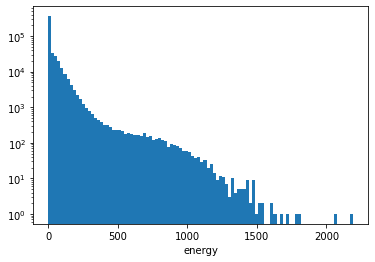

In [19]:
plt.hist(yt["energy"][msk_true_particle].flatten(), bins=100);
plt.xlabel("energy")
plt.yscale("log")

In [12]:
combined_graph_layer = {
    "max_num_bins": 100,
    "bin_size": 128,
    "distance_dim": 128,
    "layernorm": "no",
    "num_node_messages": 1,
    "dropout": 0.0,
    "kernel": {
        "type": "NodePairGaussianKernel",
        "dist_mult": 0.1,
        "clip_value_low": 0.0
    },
    "node_message": {
        "type": "GHConvDense",
        "output_dim": 128,
        "activation": "gelu",
        "normalize_degrees": "yes"
    },
    "ffn_dist_hidden_dim": 128,
    "do_lsh": "no",
    "ffn_dist_num_layers": 0,
    "activation": "gelu",
    "dist_activation": "gelu"
}

model = PFNetDense(
    num_input_classes=len(input_classes),
    num_output_classes=len(output_classes),
    activation="elu",
    hidden_dim=128,
    bin_size=128,
    input_encoding="default",
    multi_output=True,
    combined_graph_layer=combined_graph_layer
)

# #temporal weight mode means each input element in the event can get a separate weight
model.compile(
    loss={
        "cls": tf.keras.losses.CategoricalCrossentropy(from_logits=False),
        "charge": tf.keras.losses.MeanSquaredError(),
        "pt": tf.keras.losses.MeanSquaredError(),
        "energy": tf.keras.losses.MeanSquaredError(),
        "eta": tf.keras.losses.MeanSquaredError(),
        "sin_phi": tf.keras.losses.MeanSquaredError(),
        "cos_phi": tf.keras.losses.MeanSquaredError()
    },
    optimizer="adam",
    sample_weight_mode="temporal"
)

In [ ]:
model(X[:1])

In [ ]:
model.fit(X, yt, epochs=2, batch_size=5)

In [ ]:
ypred = model.predict(X, batch_size=5)

In [ ]:
#index of the class prediction output values
pred_id_offset = len(output_classes)
ypred_ids_raw = ypred["cls"]

In [ ]:
sklearn.metrics.confusion_matrix(
    np.argmax(ypred_ids_raw, axis=-1).flatten(),
    np.argmax(yt["cls"], axis=-1).flatten(), labels=output_classes
)

In [ ]:
msk_particles = (X[:, :, 0]!=0)
plt.scatter(
    ypred["eta"][msk_particles].flatten(),
    yt["eta"][msk_particles].flatten(), marker=".")